In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Initial filtering of the dataset 
## Result csv file exported for easier reference

In [ ]:
# No need to run this cell, start from the next cell
np.random.seed(1)
ratings = pd.read_csv('ratings.csv')
    
    #keep only ratings from the most recent 5 years： 2010-2015
ratings['year'] = ratings['timestamp'].apply(lambda x: date.fromtimestamp(x).year)
ratings = ratings[ratings['year']>=date.fromisoformat('2010-01-01').year]
ratings.drop(['timestamp','year'],axis=1,inplace=True) #'timestamp' and 'year' no longer useful 
    
    #keep only movies with at least 20 ratings
m_counts = ratings.groupby('movieId').size()
m_index = m_counts[m_counts>=20].index
ratings = ratings[ratings['movieId'].isin(m_index)]
    
    #keep only users who have rated at least 20 movies - consistent with original data
u_counts = ratings.groupby('userId').size()
u_index = u_counts[u_counts>=20].index
ratings = ratings[ratings['userId'].isin(u_index)]
    
ratings.to_csv("sample_data_large.csv")

In [293]:
sample=pd.read_csv("sample_data_large.csv")
sample.drop(['Unnamed: 0'],axis=1,inplace=True)
sample.head()

,userId,movieId,rating
0,25,21,3.5
1,25,22,4.0
2,25,31,3.0
3,25,32,3.5
4,25,39,4.5


In [294]:
len(sample.userId.unique()), len(sample.movieId.unique())

(29080, 9359)

# Continue sampling

 Randomly select 5000 users, 500 movies
 
 Next, 10,000 users, 1000 movies

In [295]:
user_size=5000
movie_size=500

np.random.seed(1)
user_sample=np.random.choice(sample.userId.unique(),replace=False,size=user_size)
movie_sample = np.random.choice(sample.movieId.unique(),replace = False,size = movie_size)
sample = sample[sample['userId'].isin(user_sample)]
sample = sample[sample['movieId'].isin(movie_sample)]

In [296]:
print('Number of users in the sample:', len(sample.userId.unique()))
print('Number of movies in the sample:', len(sample.movieId.unique()))

Number of users in the sample: 4536
Number of movies in the sample: 496


In [264]:
# train test split

def get_train_test(sample_data, split, seed):
    np.random.seed(seed)
    sample = sample_data

    train, test = train_test_split(sample, test_size=split)
    
    #check
    print('number of users in train:',len(np.unique(train['userId'])))
    print('number of movies in train:',len(np.unique(train['movieId'])))
    print('number of users in test:', len(np.unique(test['userId'])))
    print('number of movies in test:',len(np.unique(test['movieId'])))
    
    return train, test

In [297]:
train, test = get_train_test(sample, 0.3, 1)

number of users in train: 4222
number of movies in train: 490
number of users in test: 3211
number of movies in test: 450


# 5-Fold cross validation set up

In [298]:
kf=KFold(5,shuffle=True,random_state=1)
folds=list(kf.split(train))
folds     
#folds[0][0] contains the row numbers of data in the first train set, 
#folds[0][1] contains the row number of data in the first validation set

[(array([    1,     2,     3, ..., 22900, 22901, 22902]),
  array([    0,     4,     6, ..., 22889, 22892, 22895])),
 (array([    0,     1,     2, ..., 22900, 22901, 22902]),
  array([    5,     8,    12, ..., 22894, 22897, 22898])),
 (array([    0,     1,     2, ..., 22898, 22901, 22902]),
  array([   17,    36,    40, ..., 22888, 22899, 22900])),
 (array([    0,     4,     5, ..., 22899, 22900, 22901]),
  array([    1,     2,     3, ..., 22893, 22896, 22902])),
 (array([    0,     1,     2, ..., 22899, 22900, 22902]),
  array([   14,    15,    18, ..., 22882, 22885, 22901]))]

# Evaluation
Given a train set, a validation set (or test set), and the value of latent dimension, **get_metrics** returns the **precision**, **recall**, and **coverage** on the validation set (or test set)

In [267]:
def get_metrics(train,validation,latent_dimension=50):
    train_ratings = train.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0) #matrix form
    train_matrix=train_ratings.values      #turn into numpy nd array
    train_u, train_sigma, train_v = svds(train_matrix, latent_dimension)
    prediction_matrix=np.dot(train_u, train_v)      
    prediction=pd.DataFrame(prediction_matrix, columns=train_ratings.columns)  #turn into dataframe

    precision=0
    recall=0
    recommended_set=np.array([])
    total_users=len(validation.userId.unique())
    
    train_ratings_index=train_ratings.reset_index()  #add new index & turn userId into a column for later
    
    for u_id in validation.userId.unique():
        #find the row number for this user id
        u_row_number = train_ratings_index[train_ratings_index['userId']==u_id].index[0]

        #sorted predicted ratings for all the movies
        u_sorted_prediction = prediction.iloc[u_row_number].sort_values(ascending=False)

        # this user's ratings data in train set
        user_data=train[train['userId']==u_id]

        # top 10 recommended items (exclude movies already rated in the train set)
        recommendation=u_sorted_prediction[u_sorted_prediction.index.isin(user_data.movieId.unique())==False][:10].index.values
        
        # this user's rated movies in the validation set (relevant items in test set)
        consumed=validation[validation['userId']==u_id].movieId.unique()

        S=set(recommendation)
        G=set(consumed)
        u_precision=len(S.intersection(G))/len(S)
        u_recall=len(S.intersection(G))/len(G)

        precision += u_precision
        recall += u_recall
        
        recommended_set=np.concatenate((recommended_set,recommendation))
        
    precision=precision/total_users
    recall=recall/total_users
    coverage=len(np.unique(recommended_set))/len(validation.movieId.unique())
    
    return precision,recall,coverage

Given the entire training data and the value of latent dimension, **get_metrics_from_cv** returns the precision and recall on the train set

In [273]:
def get_metrics_from_cv(whole_train, latent_dimension=50):
    kf=KFold(5,shuffle=True,random_state=1)
    folds=list(kf.split(whole_train))
    
    precisions=[]
    recalls=[]
    coverages=[]

    for i in range(5):
        train_i=whole_train.iloc[folds[i][0],:]
        validation_i=whole_train.iloc[folds[i][1],:]

        #make sure that validation set does not have users or items that don't exist in the train set
        users = train_i.userId.unique()
        items = train_i.movieId.unique()
        validation_i = validation_i[validation_i['userId'].isin(users)]
        validation_i = validation_i[validation_i['movieId'].isin(items)]

        precision_i, recall_i, coverage_i=get_metrics(train_i, validation_i, latent_dimension)
        precisions.append(precision_i)
        recalls.append(recall_i)
        coverages.append(coverage_i)
    
    return np.mean(precisions), np.mean(recalls), np.mean(coverages)


In [282]:
#let's see the performance of svd with default 50 latent dimension 
# get_metrics_from_cv(train, 50)

(0.06378625955890986, 0.22390850021464104, 0.03268425554124059)

In [ ]:
#start=time.time()

In [299]:
latent_dimensions = [1,2,3,4,5]
precisions_k=[]
recalls_k=[]

for k in latent_dimensions:
    precision_k, recall_k, coverage_k = get_metrics_from_cv(train, k)
    precisions_k.append(precision_k)
    recalls_k.append(recall_k)
    
print(precisions_k)
print(recalls_k)

[0.06639339384702173, 0.06465390553142056, 0.058381358528566504, 0.05741703395215192, 0.054187046077479]
[0.3410111510675803, 0.3283929684118256, 0.29372425486637077, 0.2905038277927015, 0.273236777903654]


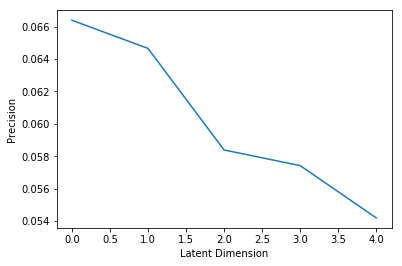

In [300]:
plt.plot(precisions_k)
plt.ylabel('Precision')
plt.xlabel('Latent Dimension')
plt.show()

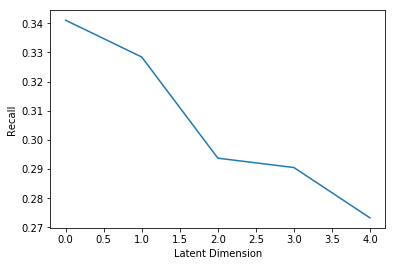

In [301]:
plt.plot(recalls_k)
plt.ylabel('Recall')
plt.xlabel('Latent Dimension')
plt.show()

In [302]:
# end=time.time()
# runtime=end-start

Current Time = 13:26:32


## Assess model performance on test set

In [303]:
#make sure that the test set does not have users or movies that don't exist in the train set
users = train.userId.unique()
items = train.movieId.unique()
test = test[test['userId'].isin(users)]
test = test[test['movieId'].isin(items)]

In [304]:
get_metrics(train, test,1)

(0.10324473593372518, 0.3423089657637019, 0.07223476297968397)